# 🌍 DỰ ĐOÁN THIỆT HẠI VỀ NGƯỜI DO THẢM HỌA GÂY RA

## Mô Hình Gradient Boosting Regressor

---

### 📋 Mô tả Dự án

**Mục tiêu:** Xây dựng mô hình Machine Learning để dự đoán số người bị chết (casualties) do các thảm họa thiên nhiên gây ra.

### 📥 Input (Đầu vào):
| Biến | Mô tả | Kiểu dữ liệu |
|------|-------|--------------|
| `country` | Quốc gia xảy ra thảm họa | Categorical |
| `disaster_type` | Loại thảm họa (Earthquake, Flood, Typhoon, ...) | Categorical |
| `severity_index` | Mức độ nghiêm trọng (0-10) | Numerical |
| `economic_loss_usd` | Thiệt hại kinh tế (USD) | Numerical |
| `response_time_hours` | Thời gian phản ứng (giờ) | Numerical |
| `response_efficiency_score` | Điểm hiệu quả phản ứng (0-100) | Numerical |
| `latitude` | Vĩ độ | Numerical |
| `longitude` | Kinh độ | Numerical |

### 📤 Output (Đầu ra):
- **`casualties`**: Số người bị chết dự đoán do thảm họa

---

### 🧠 Phương pháp: Gradient Boosting Regressor

**Gradient Boosting** là một kỹ thuật ensemble learning mạnh mẽ, hoạt động bằng cách:
1. Xây dựng nhiều decision tree tuần tự
2. Mỗi tree mới cố gắng sửa lỗi của các tree trước đó
3. Kết hợp tất cả predictions để đưa ra kết quả cuối cùng

**Ưu điểm:**
- Độ chính xác cao
- Xử lý tốt dữ liệu phi tuyến
- Có thể xác định feature importance

## 📦 PHẦN 1: IMPORT THƯ VIỆN CẦN THIẾT

Trong phần này, chúng ta sẽ import tất cả các thư viện cần thiết cho dự án:

| Thư viện | Mục đích sử dụng |
|----------|------------------|
| **pandas** | Xử lý và phân tích dữ liệu dạng bảng |
| **numpy** | Tính toán số học và làm việc với mảng |
| **matplotlib & seaborn** | Trực quan hóa dữ liệu |
| **sklearn.preprocessing** | `LabelEncoder` - mã hóa biến categorical, `StandardScaler` - chuẩn hóa dữ liệu |
| **sklearn.ensemble** | `GradientBoostingRegressor` - mô hình dự đoán chính |
| **sklearn.model_selection** | `train_test_split` - chia dữ liệu train/test |
| **sklearn.metrics** | Các metrics đánh giá: R², RMSE, MAE, MAPE |
| **joblib** | Lưu và load mô hình |

In [1]:
# ============================================================================
# IMPORT THƯ VIỆN
# ============================================================================

# Thư viện xử lý dữ liệu
import pandas as pd                    # Xử lý DataFrame
import numpy as np                     # Tính toán số học

# Thư viện trực quan hóa
import matplotlib.pyplot as plt        # Vẽ biểu đồ cơ bản
import seaborn as sns                  # Vẽ biểu đồ thống kê đẹp hơn

# Thư viện Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,                # MSE - Sai số bình phương trung bình
    r2_score,                          # R² - Hệ số xác định
    mean_absolute_error,               # MAE - Sai số tuyệt đối trung bình
    mean_absolute_percentage_error     # MAPE - Sai số phần trăm tuyệt đối trung bình
)

# Thư viện lưu mô hình
import joblib

# Tắt cảnh báo để output gọn gàng hơn
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Import thư viện thành công!")
print(f"   • pandas version: {pd.__version__}")
print(f"   • numpy version: {np.__version__}")

✅ Import thư viện thành công!
   • pandas version: 2.3.3
   • numpy version: 2.3.5


## 🏗️ PHẦN 2: ĐỊNH NGHĨA CLASS DisasterCasualtyPredictor

Chúng ta sẽ xây dựng một class để đóng gói toàn bộ pipeline dự đoán. Class này bao gồm các thành phần:

### Các thuộc tính (Attributes):
| Thuộc tính | Kiểu | Mô tả |
|------------|------|-------|
| `csv_path` | str | Đường dẫn file dữ liệu CSV |
| `df` | DataFrame | Dữ liệu đã load |
| `model` | GradientBoostingRegressor | Mô hình đã huấn luyện |
| `scaler` | StandardScaler | Bộ chuẩn hóa features |
| `label_encoders` | dict | Các encoder cho biến categorical |
| `feature_columns` | list | Danh sách tên các features |

### Các phương thức (Methods):
1. `load_data()` - Tải và khám phá dữ liệu
2. `prepare_features()` - Chuẩn bị features cho mô hình
3. `train()` - Huấn luyện mô hình
4. `predict()` - Dự đoán cho một bản ghi
5. `save_model()` / `load_model()` - Lưu/Load mô hình

In [2]:
# ============================================================================
# ĐỊNH NGHĨA CLASS DISASTERCASUALTYPREDICTOR
# ============================================================================

class DisasterCasualtyPredictor:
    """
    Mô hình dự đoán số người bị chết do thảm họa thiên nhiên
    Sử dụng thuật toán Gradient Boosting Regressor
    
    Attributes:
        csv_path (str): Đường dẫn file CSV chứa dữ liệu
        df (DataFrame): DataFrame chứa dữ liệu đã load
        model: Mô hình Gradient Boosting đã train
        scaler: StandardScaler để chuẩn hóa features
        label_encoders: Dictionary chứa LabelEncoder cho các biến categorical
        feature_columns: Danh sách tên các features
    """
    
    def __init__(self, csv_path: str):
        """
        Khởi tạo đối tượng DisasterCasualtyPredictor
        
        Parameters:
            csv_path (str): Đường dẫn đến file CSV chứa dữ liệu huấn luyện
        """
        # Đường dẫn file dữ liệu
        self.csv_path = csv_path
        
        # DataFrame chứa dữ liệu (sẽ được load sau)
        self.df = None
        
        # Dữ liệu train/test (sẽ được tạo khi train)
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        
        # Mô hình (sẽ được tạo khi train)
        self.model = None
        
        # Bộ chuẩn hóa features
        self.scaler = StandardScaler()
        
        # Dictionary chứa các LabelEncoder
        # Key: tên cột, Value: LabelEncoder object
        self.label_encoders = {}
        
        # Danh sách tên các features
        self.feature_columns = None
        
        # DataFrame chứa feature importance
        self.feature_importance_df = None
        
        print("✅ Khởi tạo DisasterCasualtyPredictor thành công!")
        print(f"   📁 File dữ liệu: {csv_path}")

## 📊 PHẦN 3: TẢI VÀ KHÁM PHÁ DỮ LIỆU

### 3.1 Phương thức `load_data()`

Phương thức này thực hiện các bước:

1. **Đọc file CSV** - Sử dụng `pandas.read_csv()` để đọc dữ liệu
2. **Hiển thị thông tin cơ bản**:
   - Số lượng bản ghi
   - Tên các cột
   - Kiểu dữ liệu của từng cột
3. **Làm sạch dữ liệu** - Loại bỏ các bản ghi không hợp lệ:
   - `severity_index <= 0` (mức độ nghiêm trọng phải > 0)
   - `casualties < 0` (số người chết không thể âm)
   - `economic_loss_usd < 0` (thiệt hại kinh tế không thể âm)
4. **Tính toán thống kê** cho biến target `casualties`

In [3]:
# ============================================================================
# THÊM PHƯƠNG THỨC LOAD_DATA VÀO CLASS
# ============================================================================

def load_data(self):
    """
    Tải và khám phá dữ liệu từ file CSV
    
    Các bước thực hiện:
    1. Đọc file CSV vào DataFrame
    2. Hiển thị thông tin cơ bản về dataset
    3. Làm sạch dữ liệu (loại bỏ các bản ghi không hợp lệ)
    4. Tính toán và hiển thị thống kê mô tả
    
    Returns:
        DataFrame: Dữ liệu đã được làm sạch
    """
    print("=" * 80)
    print("📊 BƯỚC 1: TẢI VÀ KHÁM PHÁ DỮ LIỆU")
    print("=" * 80)
    
    # 1. Đọc file CSV
    self.df = pd.read_csv(self.csv_path)
    print(f"\n✅ Tải thành công {len(self.df):,} bản ghi")
    print(f"📋 Các cột trong dataset: {list(self.df.columns)}")
    
    # 2. Hiển thị thông tin về kiểu dữ liệu
    print(f"\n📝 THÔNG TIN KIỂU DỮ LIỆU:")
    print(self.df.dtypes)
    
    # 3. Kiểm tra missing values
    print(f"\n🔍 KIỂM TRA MISSING VALUES:")
    missing = self.df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "   Không có missing values!")
    
    # 4. Làm sạch dữ liệu
    print(f"\n🧹 LÀM SẠCH DỮ LIỆU:")
    before_clean = len(self.df)
    
    # Loại bỏ các bản ghi không hợp lệ
    self.df = self.df[self.df['severity_index'] > 0].copy()
    self.df = self.df[self.df['casualties'] >= 0].copy()
    self.df = self.df[self.df['economic_loss_usd'] >= 0].copy()
    
    after_clean = len(self.df)
    print(f"   • Trước làm sạch: {before_clean:,} bản ghi")
    print(f"   • Sau làm sạch: {after_clean:,} bản ghi")
    print(f"   • Đã loại bỏ: {before_clean - after_clean:,} bản ghi không hợp lệ")
    
    # 5. Thống kê mô tả cho biến target
    print(f"\n📈 THỐNG KÊ BIẾN TARGET (CASUALTIES):")
    print(f"   • Giá trị nhỏ nhất (Min): {self.df['casualties'].min():.0f} người")
    print(f"   • Giá trị lớn nhất (Max): {self.df['casualties'].max():.0f} người")
    print(f"   • Trung bình (Mean): {self.df['casualties'].mean():.2f} người")
    print(f"   • Trung vị (Median): {self.df['casualties'].median():.0f} người")
    print(f"   • Độ lệch chuẩn (Std): {self.df['casualties'].std():.2f}")
    
    return self.df

# Gắn phương thức vào class
DisasterCasualtyPredictor.load_data = load_data

print("✅ Đã định nghĩa phương thức load_data()")

✅ Đã định nghĩa phương thức load_data()


### 3.2 Khởi tạo và tải dữ liệu

Ta có khời tạo sau :
1. Tạo đối tượng `DisasterCasualtyPredictor` với đường dẫn file CSV
2. Gọi phương thức `load_data()` để tải và khám phá dữ liệu

In [4]:
# ============================================================================
# KHỞI TẠO VÀ TẢI DỮ LIỆU
# ============================================================================

# Đường dẫn file dữ liệu
CSV_PATH = "du_lieu_sach.csv"

# Tạo đối tượng predictor
predictor = DisasterCasualtyPredictor(CSV_PATH)

# Tải dữ liệu
df = predictor.load_data()

✅ Khởi tạo DisasterCasualtyPredictor thành công!
   📁 File dữ liệu: du_lieu_sach.csv
📊 BƯỚC 1: TẢI VÀ KHÁM PHÁ DỮ LIỆU

✅ Tải thành công 50,000 bản ghi
📋 Các cột trong dataset: ['date', 'country', 'disaster_type', 'severity_index', 'casualties', 'economic_loss_usd', 'response_time_hours', 'aid_amount_usd', 'response_efficiency_score', 'recovery_days', 'latitude', 'longitude', 'continent']

📝 THÔNG TIN KIỂU DỮ LIỆU:
date                          object
country                       object
disaster_type                 object
severity_index               float64
casualties                     int64
economic_loss_usd            float64
response_time_hours          float64
aid_amount_usd               float64
response_efficiency_score    float64
recovery_days                  int64
latitude                     float64
longitude                    float64
continent                     object
dtype: object

🔍 KIỂM TRA MISSING VALUES:
   Không có missing values!

🧹 LÀM SẠCH DỮ LIỆU:
   • Trướ

### 📖 CHÚ THÍCH CÁC CỘT DỮ LIỆU

| Cột | Tiếng Việt | Mô tả |
|-----|------------|-------|
| `date` | Ngày xảy ra | Ngày thảm họa |
| `country` | Quốc gia | Nơi xảy ra thảm họa |
| `disaster_type` | Loại thảm họa | Earthquake, Flood, Typhoon, ... |
| `severity_index` | Mức độ nghiêm trọng | 0-10 |
| `casualties` | **Số người chết** | **TARGET** - Biến cần dự đoán |
| `economic_loss_usd` | Thiệt hại kinh tế | USD |
| `response_time_hours` | Thời gian phản ứng | Giờ |
| `aid_amount_usd` | Tiền viện trợ | USD |
| `response_efficiency_score` | Điểm hiệu quả | 0-100 |
| `recovery_days` | Ngày phục hồi | Số ngày |
| `latitude` | Vĩ độ | -90 → 90 |
| `longitude` | Kinh độ | -180 → 180 |
| `continent` | Châu lục | Asia, Europe, ... |

**Sử dụng:** `country`, `disaster_type`, `severity_index`, `economic_loss_usd`, `response_time_hours`, `response_efficiency_score`, `latitude`, `longitude`  
**Không dùng:** `date`, `aid_amount_usd`, `recovery_days`, `continent`

## 📈 PHẦN 4: PHÂN TÍCH THỐNG KÊ DỮ LIỆU

### 4.1 Thống kê tổng quát

Xem nhanh cấu trúc và thống kê cơ bản của toàn bộ dataset.

In [5]:
# ============================================================================
# THỐNG KÊ TỔNG QUÁT
# ============================================================================

# Xem 5 dòng đầu tiên
print("📋 5 DÒNG DỮ LIỆU ĐẦU TIÊN:")
display(df.head())

# Thống kê mô tả cho các biến số
print("\n📊 THỐNG KÊ MÔ TẢ CHO CÁC BIẾN SỐ:")
display(df.describe())

📋 5 DÒNG DỮ LIỆU ĐẦU TIÊN:


,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude,continent
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557,America
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194,America
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978,Asia
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350,Asia
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137,America



📊 THỐNG KÊ MÔ TẢ CHO CÁC BIẾN SỐ:


,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
count,50000.000000,50000.000000,5.000000e+04,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.015769,100.591140,5.068593e+06,12.183027,2.500003e+05,87.574025,49.682560,0.231205,0.089889
std,1.942843,65.052064,3.268541e+06,9.259081,1.432275e+05,10.188961,20.098944,34.759662,98.380208
min,1.000000,0.000000,5.273900e+02,1.000000,1.660000e+01,29.750000,2.000000,-59.994000,-169.998000
25%,3.660000,51.000000,2.585513e+06,6.270000,1.429663e+05,83.060000,36.000000,-29.848250,-85.551750
50%,4.990000,91.000000,4.548351e+06,10.510000,2.305365e+05,89.180000,49.000000,0.267500,0.390500
75%,6.340000,138.000000,6.950615e+06,15.450000,3.352259e+05,94.700000,63.000000,30.488250,85.665000
max,10.000000,524.000000,2.445624e+07,63.100000,1.126465e+06,100.000000,112.000000,59.997000,169.999000


### 4.2 Phân tích theo loại thảm họa

Phân tích số người bị chết (casualties) theo từng loại thảm họa để hiểu rõ hơn về mức độ nguy hiểm của từng loại.

In [6]:
# ============================================================================
# PHÂN TÍCH CASUALTIES THEO LOẠI THẢM HỌA
# ============================================================================

print("📊 CASUALTIES THEO LOẠI THẢM HỌA:")
print("-" * 80)

# Tính toán thống kê theo loại thảm họa
disaster_stats = df.groupby('disaster_type').agg({
    'casualties': ['count', 'mean', 'sum', 'min', 'max', 'std']
}).round(2)

# Đổi tên cột cho dễ đọc
disaster_stats.columns = ['Số vụ', 'TB người chết', 'Tổng', 'Min', 'Max', 'Std']
disaster_stats = disaster_stats.sort_values('TB người chết', ascending=False)

display(disaster_stats)

# Tổng quan
print(f"\n📊 TỔNG QUAN:")
print(f"   • Tổng số loại thảm họa: {df['disaster_type'].nunique()}")
print(f"   • Loại gây thiệt hại nhiều nhất: {disaster_stats['TB người chết'].idxmax()}")
print(f"   • Loại có nhiều vụ nhất: {disaster_stats['Số vụ'].idxmax()}")

📊 CASUALTIES THEO LOẠI THẢM HỌA:
--------------------------------------------------------------------------------


,Số vụ,TB người chết,Tổng,Min,Max,Std
disaster_type,,,,,,
Tornado,4939,102.21,504802,0,477,66.34
Storm Surge,4988,101.26,505083,0,431,64.93
Wildfire,4954,101.22,501444,0,454,65.22
Landslide,5130,100.58,515999,0,524,64.77
Volcanic Eruption,4983,100.55,501022,0,394,65.22
Drought,4896,100.41,491618,0,391,64.67
Hurricane,5002,100.27,501555,0,438,64.84
Earthquake,5068,100.01,506829,0,415,64.42
Flood,5039,99.91,503454,0,445,65.19



📊 TỔNG QUAN:
   • Tổng số loại thảm họa: 10
   • Loại gây thiệt hại nhiều nhất: Tornado
   • Loại có nhiều vụ nhất: Landslide


## 📊 PHẦN 5: TRỰC QUAN HÓA DỮ LIỆU

Ta sẽ tạo các biểu đồ để hiểu rõ hơn về dữ liệu:

1. **Histogram** - Phân phối của biến target (casualties)
2. **Boxplot** - So sánh casualties giữa các loại thảm họa
3. **Heatmap** - Ma trận tương quan giữa các biến số
4. **Scatter plot** - Mối quan hệ giữa severity_index và casualties

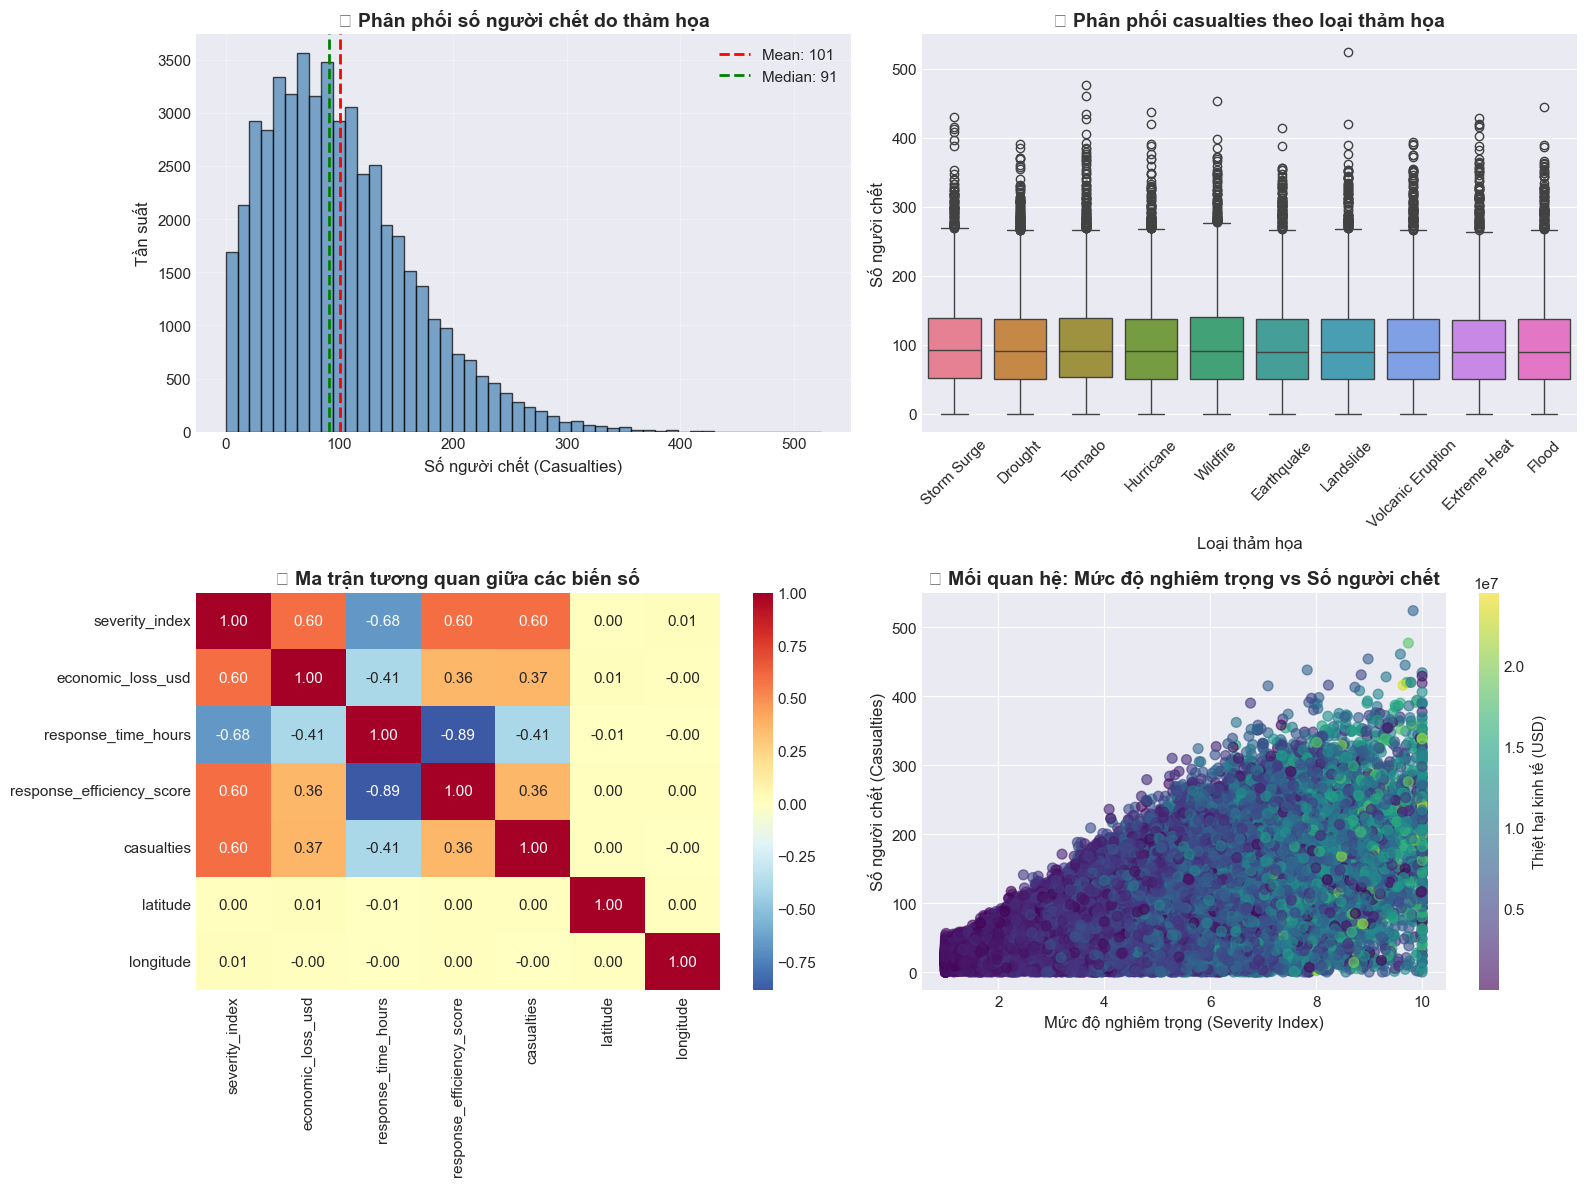

✅ Đã lưu biểu đồ tại: figures/data_exploration.png


In [7]:
# ============================================================================
# TRỰC QUAN HÓA DỮ LIỆU
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram - Phân phối của casualties
ax1 = axes[0, 0]
ax1.hist(df['casualties'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['casualties'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["casualties"].mean():.0f}')
ax1.axvline(df['casualties'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["casualties"].median():.0f}')
ax1.set_xlabel('Số người chết (Casualties)', fontsize=12)
ax1.set_ylabel('Tần suất', fontsize=12)
ax1.set_title('📊 Phân phối số người chết do thảm họa', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Boxplot - Casualties theo loại thảm họa
ax2 = axes[0, 1]
disaster_order = df.groupby('disaster_type')['casualties'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='disaster_type', y='casualties', order=disaster_order, ax=ax2, palette='husl')
ax2.set_xlabel('Loại thảm họa', fontsize=12)
ax2.set_ylabel('Số người chết', fontsize=12)
ax2.set_title('📦 Phân phối casualties theo loại thảm họa', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# 3. Heatmap - Ma trận tương quan
ax3 = axes[1, 0]
numeric_cols = ['severity_index', 'economic_loss_usd', 'response_time_hours', 
                'response_efficiency_score', 'casualties', 'latitude', 'longitude']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f', ax=ax3)
ax3.set_title('🔥 Ma trận tương quan giữa các biến số', fontsize=14, fontweight='bold')

# 4. Scatter plot - Severity vs Casualties
ax4 = axes[1, 1]
scatter = ax4.scatter(df['severity_index'], df['casualties'], 
                      c=df['economic_loss_usd'], cmap='viridis', 
                      alpha=0.6, s=50)
ax4.set_xlabel('Mức độ nghiêm trọng (Severity Index)', fontsize=12)
ax4.set_ylabel('Số người chết (Casualties)', fontsize=12)
ax4.set_title('📈 Mối quan hệ: Mức độ nghiêm trọng vs Số người chết', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Thiệt hại kinh tế (USD)')

plt.tight_layout()
plt.savefig('figures/data_exploration.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Đã lưu biểu đồ tại: figures/data_exploration.png")

## 🔧 PHẦN 6: CHUẨN BỊ FEATURES VÀ ENCODING

### 6.1 Feature Engineering

**Feature Engineering** là quá trình chuyển đổi dữ liệu thô thành các features phù hợp cho mô hình Machine Learning.

#### Các features được sử dụng:

| Feature | Loại | Xử lý |
|---------|------|-------|
| `country` | Categorical | LabelEncoder - Chuyển tên quốc gia thành số |
| `disaster_type` | Categorical | LabelEncoder - Chuyển loại thảm họa thành số |
| `severity_index` | Numerical | Giữ nguyên (0-10) |
| `economic_loss_usd` | Numerical | Chuẩn hóa với StandardScaler |
| `response_time_hours` | Numerical | Chuẩn hóa với StandardScaler |
| `response_efficiency_score` | Numerical | Giữ nguyên (0-100) |
| `latitude` | Numerical | Chuẩn hóa với StandardScaler |
| `longitude` | Numerical | Chuẩn hóa với StandardScaler |

#### Tại sao cần encoding và chuẩn hóa?

1. **LabelEncoder**: Mô hình ML chỉ làm việc được với số, không phải text
2. **StandardScaler**: Đưa các features về cùng thang đo (mean=0, std=1) để mô hình học tốt hơn

In [8]:
# ============================================================================
# THÊM PHƯƠNG THỨC PREPARE_FEATURES VÀO CLASS
# ============================================================================

def prepare_features(self, df=None, fit_encoders=True):
    """
    Chuẩn bị features cho mô hình Machine Learning
    
    Quy trình xử lý:
    1. Loại bỏ các cột không cần thiết (date, aid_amount_usd, recovery_days, continent)
    2. Tách biến target (casualties) ra khỏi features
    3. Xác định các cột features cần sử dụng
    4. Encode các biến categorical (country, disaster_type) bằng LabelEncoder
    
    Parameters:
        df (DataFrame): DataFrame để xử lý. Nếu None, dùng self.df
        fit_encoders (bool): True nếu cần fit encoder (training), False nếu chỉ transform (prediction)
    
    Returns:
        X (np.ndarray): Mảng features đã xử lý
        y (np.ndarray): Mảng target values (casualties)
    """
    # Sử dụng df được truyền vào hoặc self.df
    if df is None:
        df = self.df.copy()
    else:
        df = df.copy()
    
    # Loại bỏ các cột không cần thiết cho dự đoán
    # - date: Không dùng vì không có ý nghĩa trực tiếp
    # - aid_amount_usd: Đây là kết quả, không phải input
    # - recovery_days: Đây cũng là kết quả
    # - continent: Đã có country
    cols_to_drop = ['date', 'aid_amount_usd', 'recovery_days', 'continent']
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Tách biến target (y)
    y = df['casualties'].values
    
    # Xác định các cột features (X)
    feature_cols = [
        'country',                    # Quốc gia (categorical)
        'disaster_type',              # Loại thảm họa (categorical)
        'severity_index',             # Mức độ nghiêm trọng (numerical)
        'economic_loss_usd',          # Thiệt hại kinh tế (numerical)
        'response_time_hours',        # Thời gian phản ứng (numerical)
        'response_efficiency_score',  # Điểm hiệu quả phản ứng (numerical)
        'latitude',                   # Vĩ độ (numerical)
        'longitude'                   # Kinh độ (numerical)
    ]
    
    X = df[feature_cols].copy()
    
    # Encode các biến categorical
    categorical_cols = ['country', 'disaster_type']
    
    for col in categorical_cols:
        if fit_encoders:
            # Training mode: fit và transform
            if col not in self.label_encoders:
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le
                print(f"   ✅ Đã encode '{col}': {len(le.classes_)} categories")
            else:
                X[col] = self.label_encoders[col].transform(X[col].astype(str))
        else:
            # Prediction mode: chỉ transform
            try:
                X[col] = self.label_encoders[col].transform(X[col].astype(str))
            except ValueError as e:
                print(f"   ⚠️  '{col}' chứa giá trị không có trong dữ liệu huấn luyện!")
                X[col] = -1  # Gán giá trị đặc biệt cho unknown
    
    # Lưu lại danh sách feature columns
    self.feature_columns = feature_cols
    
    return X.values, y

# Gắn phương thức vào class
DisasterCasualtyPredictor.prepare_features = prepare_features

print("✅ Đã định nghĩa phương thức prepare_features()")

✅ Đã định nghĩa phương thức prepare_features()


## ✂️ PHẦN 7: CHIA DỮ LIỆU TRAIN/TEST

Chia dữ liệu thành **Train set** và **Test set** để:
1. **Train set (80%)**: Dùng để huấn luyện mô hình
2. **Test set (20%)**: Dùng để đánh giá mô hình trên dữ liệu chưa từng thấy

**StandardScaler** chuẩn hóa dữ liệu theo công thức:
$$z = \frac{x - \mu}{\sigma}$$

Trong đó:
- $x$: Giá trị gốc
- $\mu$: Giá trị trung bình
- $\sigma$: Độ lệch chuẩn
- $z$: Giá trị đã chuẩn hóa (mean=0, std=1)

**Lưu ý quan trọng:**
- **fit_transform** chỉ dùng trên Train set
- **transform** dùng trên Test set (để tránh data leakage)

In [9]:
# ============================================================================
# THÊM PHƯƠNG THỨC TRAIN VÀO CLASS
# ============================================================================

def train(self, test_size=0.2, random_state=42):
    """
    Huấn luyện mô hình Gradient Boosting Regressor
    
    Quy trình:
    1. Chuẩn bị features (encode categorical, tách X và y)
    2. Chia dữ liệu train/test theo tỷ lệ 80/20
    3. Chuẩn hóa features bằng StandardScaler
    4. Huấn luyện mô hình Gradient Boosting
    5. Đánh giá mô hình trên cả train và test set
    
    Parameters:
        test_size (float): Tỷ lệ test set (default: 0.2 = 20%)
        random_state (int): Seed để tái tạo kết quả (default: 42)
    
    Returns:
        dict: Dictionary chứa các metrics đánh giá
    """
    print("\n" + "=" * 80)
    print("🔧 BƯỚC 2: CHUẨN BỊ VÀ HUẤN LUYỆN MÔ HÌNH")
    print("=" * 80)
    
    # =====================================================================
    # BƯỚC 2.1: CHUẨN BỊ FEATURES
    # =====================================================================
    print("\n📊 Chuẩn bị features...")
    X, y = self.prepare_features(fit_encoders=True)
    
    print(f"\n   📐 Kích thước dữ liệu:")
    print(f"      • X (features): {X.shape}")
    print(f"      • y (target): {y.shape}")
    
    # =====================================================================
    # BƯỚC 2.2: CHIA DỮ LIỆU TRAIN/TEST
    # =====================================================================
    print(f"\n✂️  Chia dữ liệu train/test (tỷ lệ {int((1-test_size)*100)}/{int(test_size*100)})...")
    
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )
    
    print(f"\n   📊 KẾT QUẢ CHIA DỮ LIỆU:")
    print(f"      • Train set: {len(self.X_train):,} mẫu ({(1-test_size)*100:.0f}%)")
    print(f"      • Test set: {len(self.X_test):,} mẫu ({test_size*100:.0f}%)")
    
    # =====================================================================
    # BƯỚC 2.3: CHUẨN HÓA FEATURES
    # =====================================================================
    print(f"\n📏 Chuẩn hóa features với StandardScaler...")
    
    # fit_transform trên train set
    self.X_train_scaled = self.scaler.fit_transform(self.X_train)
    # chỉ transform trên test set (QUAN TRỌNG!)
    self.X_test_scaled = self.scaler.transform(self.X_test)
    
    print(f"   ✅ Đã chuẩn hóa features")
    print(f"      • Mean sau chuẩn hóa (train): {self.X_train_scaled.mean():.6f}")
    print(f"      • Std sau chuẩn hóa (train): {self.X_train_scaled.std():.6f}")
    
    # =====================================================================
    # BƯỚC 2.4: HUẤN LUYỆN MÔ HÌNH
    # =====================================================================
    print(f"\n🚀 HUẤN LUYỆN MÔ HÌNH GRADIENT BOOSTING...")
    print(f"\n   ⚙️  Hyperparameters:")
    print(f"      • n_estimators: 300 (số cây)")
    print(f"      • learning_rate: 0.08 (tốc độ học)")
    print(f"      • max_depth: 6 (độ sâu tối đa)")
    print(f"      • min_samples_split: 5")
    print(f"      • min_samples_leaf: 2")
    print(f"      • subsample: 0.8 (tỷ lệ mẫu)")
    
    self.model = GradientBoostingRegressor(
        n_estimators=300,           # Số lượng cây decision tree
        learning_rate=0.08,         # Tốc độ học - nhỏ hơn = học chậm hơn nhưng chính xác hơn
        max_depth=6,                # Độ sâu tối đa của mỗi cây
        min_samples_split=5,        # Số mẫu tối thiểu để split một node
        min_samples_leaf=2,         # Số mẫu tối thiểu ở leaf node
        subsample=0.8,              # Tỷ lệ mẫu dùng cho mỗi cây
        random_state=random_state,  # Seed để tái tạo kết quả
        verbose=0                   # Không hiện progress bar
    )
    
    # Fit mô hình trên training data
    self.model.fit(self.X_train_scaled, self.y_train)
    
    print(f"\n   ✅ Hoàn thành huấn luyện!")
    
    # =====================================================================
    # BƯỚC 2.5: ĐÁNH GIÁ MÔ HÌNH
    # =====================================================================
    return self._evaluate_model()

# Gắn phương thức vào class
DisasterCasualtyPredictor.train = train

print("✅ Đã định nghĩa phương thức train()")

✅ Đã định nghĩa phương thức train()


## 📈 PHẦN 8: ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH

### Metrics:
- **R² = 0.85** nghĩa là mô hình giải thích được 85% biến động của dữ liệu
- **RMSE = 50** nghĩa là sai số trung bình khoảng 50 người
- **MAE = 30** nghĩa là trung bình mô hình dự đoán sai khoảng 30 người
- **MAPE = 10%** nghĩa là sai số trung bình khoảng 10% so với giá trị thực

In [10]:
# ============================================================================
# THÊM PHƯƠNG THỨC ĐÁNH GIÁ MÔ HÌNH
# ============================================================================

def _evaluate_model(self):
    """
    Đánh giá mô hình trên cả Train và Test set
    
    Tính toán các metrics:
    - R² Score: Hệ số xác định
    - RMSE: Root Mean Squared Error
    - MAE: Mean Absolute Error  
    - MAPE: Mean Absolute Percentage Error
    
    Returns:
        dict: Dictionary chứa tất cả các metrics
    """
    print("\n" + "=" * 80)
    print("📈 BƯỚC 3: ĐÁNH GIÁ MÔ HÌNH")
    print("=" * 80)
    
    # Dự đoán trên cả train và test set
    y_pred_train = self.model.predict(self.X_train_scaled)
    y_pred_test = self.model.predict(self.X_test_scaled)
    
    # Tính các metrics cho Train set
    train_r2 = r2_score(self.y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(self.y_train, y_pred_train))
    train_mae = mean_absolute_error(self.y_train, y_pred_train)
    train_mape = mean_absolute_percentage_error(self.y_train, y_pred_train)
    
    # Tính các metrics cho Test set
    test_r2 = r2_score(self.y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
    test_mae = mean_absolute_error(self.y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(self.y_test, y_pred_test)
    
    # Hiển thị bảng kết quả
    print(f"\n📊 KẾT QUẢ ĐÁNH GIÁ:")
    print(f"\n   {'Metric':<30} {'Train':<20} {'Test':<20}")
    print(f"   {'-' * 70}")
    print(f"   {'R² Score':<30} {train_r2:<20.4f} {test_r2:<20.4f}")
    print(f"   {'RMSE (người)':<30} {train_rmse:<20.2f} {test_rmse:<20.2f}")
    print(f"   {'MAE (người)':<30} {train_mae:<20.2f} {test_mae:<20.2f}")
    print(f"   {'MAPE (%)':<30} {train_mape*100:<20.2f} {test_mape*100:<20.2f}")
    
    # Đánh giá mô hình
    print(f"\n🔍 NHẬN XÉT:")
    if test_r2 > 0.8:
        print(f"   ✅ R² > 0.8: Mô hình giải thích tốt biến động của dữ liệu")
    elif test_r2 > 0.6:
        print(f"   ⚠️  R² trong khoảng 0.6-0.8: Mô hình khá tốt")
    else:
        print(f"   ❌ R² < 0.6: Mô hình cần cải thiện")
    
    if abs(train_r2 - test_r2) < 0.1:
        print(f"   ✅ Chênh lệch Train/Test nhỏ: Không có overfitting nghiêm trọng")
    else:
        print(f"   ⚠️  Chênh lệch Train/Test lớn: Có thể bị overfitting")
    
    # Lưu lại predictions để visualization
    self.y_pred_train = y_pred_train
    self.y_pred_test = y_pred_test
    
    return {
        'train_r2': train_r2, 'test_r2': test_r2,
        'train_rmse': train_rmse, 'test_rmse': test_rmse,
        'train_mae': train_mae, 'test_mae': test_mae,
        'train_mape': train_mape, 'test_mape': test_mape
    }

# Gắn phương thức vào class
DisasterCasualtyPredictor._evaluate_model = _evaluate_model

print("✅ Đã định nghĩa phương thức _evaluate_model()")

✅ Đã định nghĩa phương thức _evaluate_model()


### 8.1 Huấn luyện và đánh giá mô hình

Chạy toàn bộ quy trình huấn luyện:

In [11]:
# ============================================================================
# HUẤN LUYỆN MÔ HÌNH
# ============================================================================

# Huấn luyện với tỷ lệ test_size = 20%, random_state = 42
metrics = predictor.train(test_size=0.2, random_state=42)


🔧 BƯỚC 2: CHUẨN BỊ VÀ HUẤN LUYỆN MÔ HÌNH

📊 Chuẩn bị features...
   ✅ Đã encode 'country': 20 categories
   ✅ Đã encode 'disaster_type': 10 categories

   📐 Kích thước dữ liệu:
      • X (features): (50000, 8)
      • y (target): (50000,)

✂️  Chia dữ liệu train/test (tỷ lệ 80/20)...

   📊 KẾT QUẢ CHIA DỮ LIỆU:
      • Train set: 40,000 mẫu (80%)
      • Test set: 10,000 mẫu (20%)

📏 Chuẩn hóa features với StandardScaler...
   ✅ Đã chuẩn hóa features
      • Mean sau chuẩn hóa (train): -0.000000
      • Std sau chuẩn hóa (train): 1.000000

🚀 HUẤN LUYỆN MÔ HÌNH GRADIENT BOOSTING...

   ⚙️  Hyperparameters:
      • n_estimators: 300 (số cây)
      • learning_rate: 0.08 (tốc độ học)
      • max_depth: 6 (độ sâu tối đa)
      • min_samples_split: 5
      • min_samples_leaf: 2
      • subsample: 0.8 (tỷ lệ mẫu)

   ✅ Hoàn thành huấn luyện!

📈 BƯỚC 3: ĐÁNH GIÁ MÔ HÌNH

📊 KẾT QUẢ ĐÁNH GIÁ:

   Metric                         Train                Test                
   -----------------------

## ⭐ PHẦN 9: PHÂN TÍCH FEATURE IMPORTANCE

### Feature Importance ?

**Feature Importance** cho biết mức độ đóng góp của từng feature vào kết quả dự đoán của mô hình.

Trong Gradient Boosting:
- Importance được tính dựa trên số lần feature được sử dụng để split và mức độ cải thiện
- Giá trị cao = Feature quan trọng, ảnh hưởng nhiều đến dự đoán
- Giá trị thấp = Feature ít quan trọng

**Ứng dụng:**
1. Hiểu mô hình đang học những gì
2. Xác định các yếu tố ảnh hưởng nhiều nhất đến thiệt hại người
3. Có thể loại bỏ các features không quan trọng để đơn giản hóa mô hình

⭐ PHÂN TÍCH TẦM QUAN TRỌNG CỦA CÁC FEATURES

📊 BẢNG TẦM QUAN TRỌNG:
--------------------------------------------------------------------------------
   Mức độ nghiêm trọng             66.75% █████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
   Thiệt hại kinh tế (USD)          7.51% ███████████████
   Vĩ độ                            6.04% ████████████
   Kinh độ                          5.98% ███████████
   Điểm hiệu quả phản ứng           4.84% █████████
   Thời gian phản ứng (giờ)         4.67% █████████
   Quốc gia                         2.41% ████
   Loại thảm họa                    1.80% ███


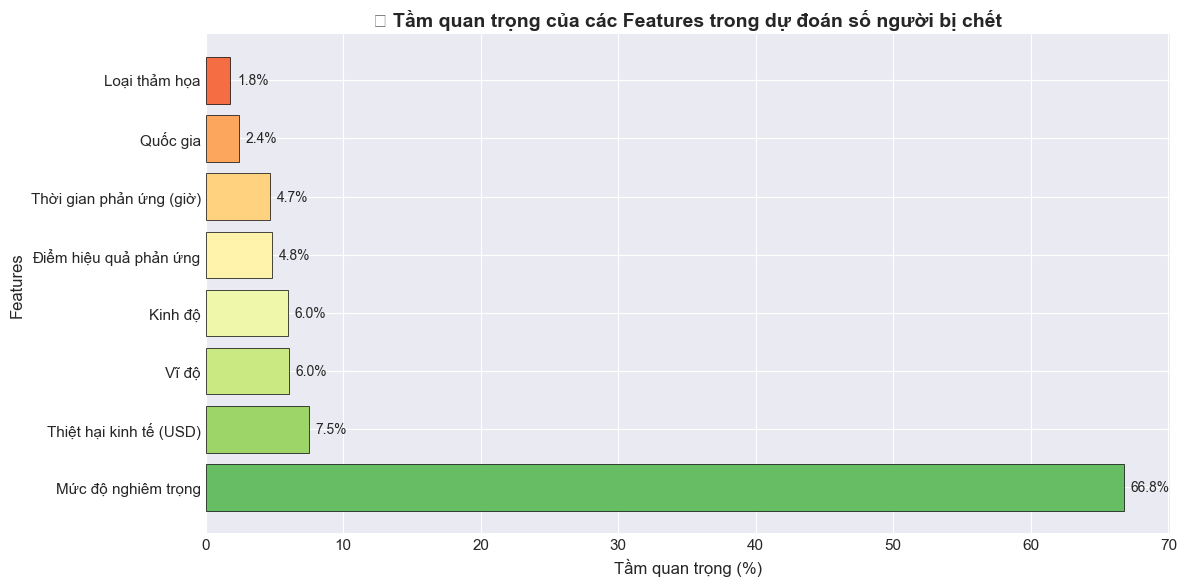


✅ Đã lưu biểu đồ tại: figures/feature_importance.png


In [12]:
# ============================================================================
# PHÂN TÍCH FEATURE IMPORTANCE
# ============================================================================

print("=" * 80)
print("⭐ PHÂN TÍCH TẦM QUAN TRỌNG CỦA CÁC FEATURES")
print("=" * 80)

# Tạo DataFrame feature importance
feature_importance_df = pd.DataFrame({
    'Feature': predictor.feature_columns,
    'Importance': predictor.model.feature_importances_
}).sort_values('Importance', ascending=False)

# Thêm cột giải thích tiếng Việt
feature_names_vi = {
    'country': 'Quốc gia',
    'disaster_type': 'Loại thảm họa',
    'severity_index': 'Mức độ nghiêm trọng',
    'economic_loss_usd': 'Thiệt hại kinh tế (USD)',
    'response_time_hours': 'Thời gian phản ứng (giờ)',
    'response_efficiency_score': 'Điểm hiệu quả phản ứng',
    'latitude': 'Vĩ độ',
    'longitude': 'Kinh độ'
}
feature_importance_df['Tên tiếng Việt'] = feature_importance_df['Feature'].map(feature_names_vi)
feature_importance_df['Importance (%)'] = (feature_importance_df['Importance'] * 100).round(2)

# Hiển thị bảng
print("\n📊 BẢNG TẦM QUAN TRỌNG:")
print("-" * 80)
for idx, row in feature_importance_df.iterrows():
    bar = '█' * int(row['Importance (%)'] * 2)
    print(f"   {row['Tên tiếng Việt']:<30} {row['Importance (%)']:>6.2f}% {bar}")

# Lưu vào predictor
predictor.feature_importance_df = feature_importance_df

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance_df)))[::-1]
bars = ax.barh(feature_importance_df['Tên tiếng Việt'], 
               feature_importance_df['Importance (%)'], 
               color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Tầm quan trọng (%)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('⭐ Tầm quan trọng của các Features trong dự đoán số người bị chết', 
             fontsize=14, fontweight='bold')

# Thêm giá trị trên mỗi bar
for bar, val in zip(bars, feature_importance_df['Importance (%)']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Đã lưu biểu đồ tại: figures/feature_importance.png")

## 📊 PHẦN 10: TRỰC QUAN HÓA KẾT QUẢ DỰ ĐOÁN

### Các biểu đồ đánh giá:

1. **Actual vs Predicted Plot**: So sánh giá trị thực và dự đoán
   - Điểm gần đường y=x = Dự đoán tốt
   
2. **Residual Plot**: Biểu đồ phần dư (sai số)
   - Phần dư = Giá trị thực - Giá trị dự đoán
   - Mong muốn: Phần dư phân bố ngẫu nhiên quanh 0
   
3. **Histogram of Residuals**: Phân phối của phần dư
   - Mong muốn: Phân phối chuẩn với mean ≈ 0

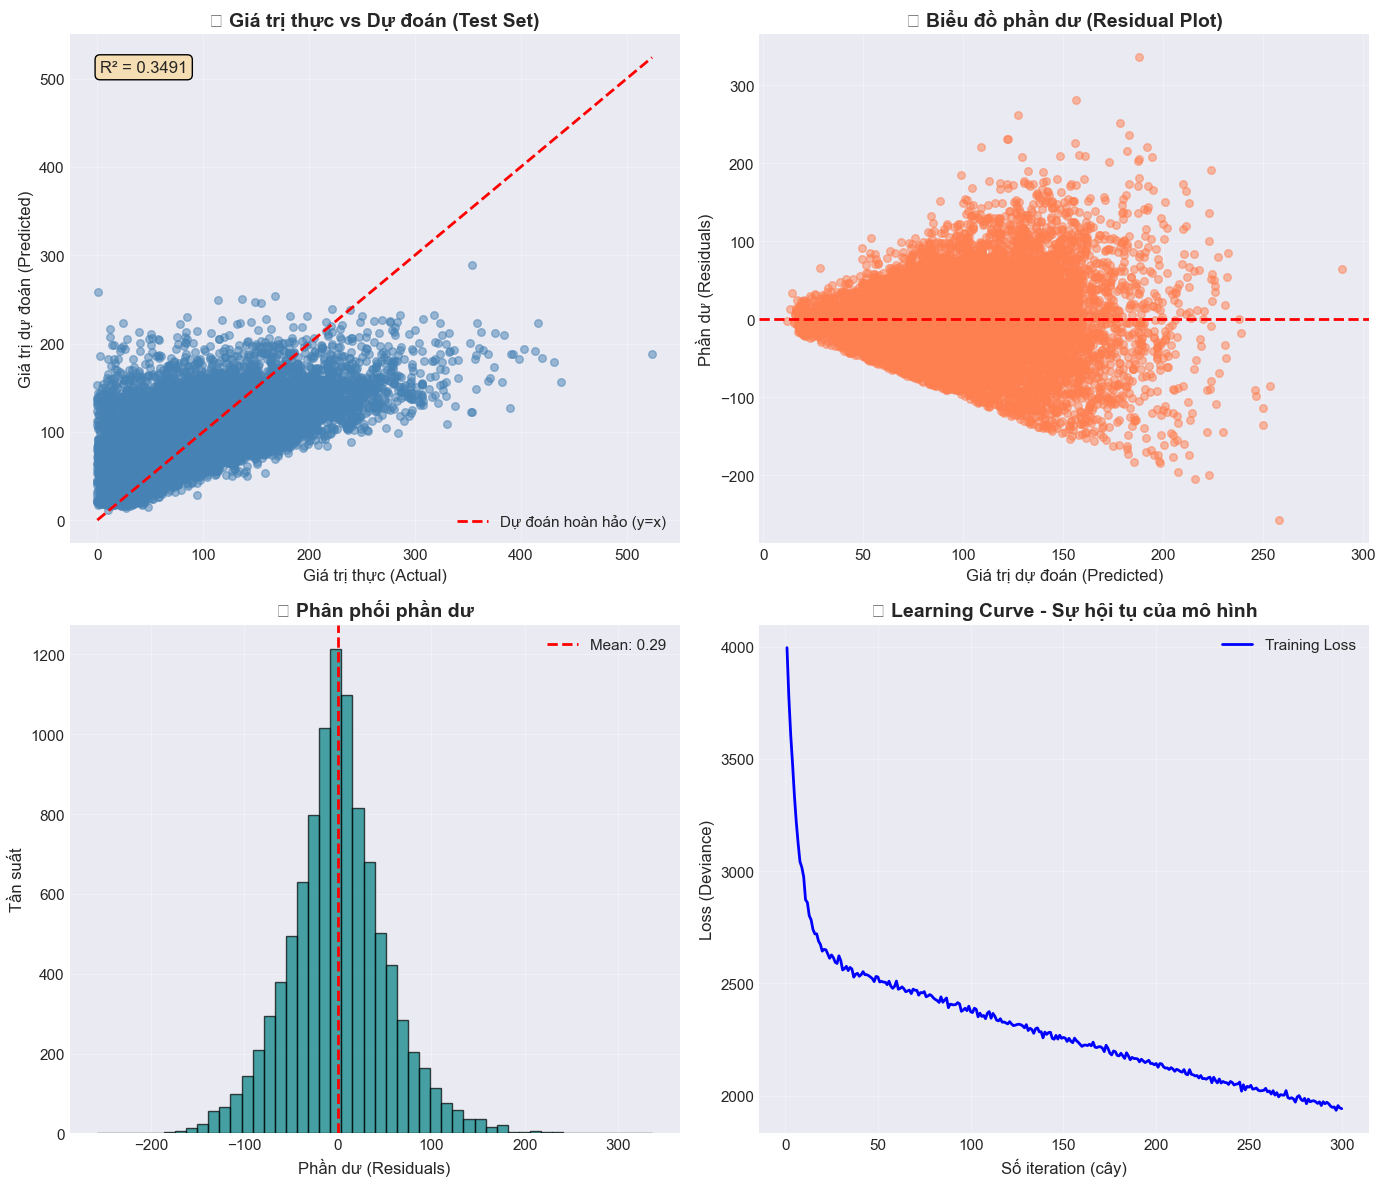

✅ Đã lưu biểu đồ tại: figures/model_evaluation.png


In [13]:
# ============================================================================
# TRỰC QUAN HÓA KẾT QUẢ DỰ ĐOÁN
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# =========================================================================
# 1. ACTUAL VS PREDICTED (TEST SET)
# =========================================================================
ax1 = axes[0, 0]
ax1.scatter(predictor.y_test, predictor.y_pred_test, alpha=0.5, s=30, c='steelblue')
# Vẽ đường y = x (perfect prediction)
max_val = max(predictor.y_test.max(), predictor.y_pred_test.max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Dự đoán hoàn hảo (y=x)')
ax1.set_xlabel('Giá trị thực (Actual)', fontsize=12)
ax1.set_ylabel('Giá trị dự đoán (Predicted)', fontsize=12)
ax1.set_title('📊 Giá trị thực vs Dự đoán (Test Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Thêm R² vào biểu đồ
ax1.text(0.05, 0.95, f"R² = {metrics['test_r2']:.4f}", 
         transform=ax1.transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# =========================================================================
# 2. RESIDUAL PLOT
# =========================================================================
ax2 = axes[0, 1]
residuals = predictor.y_test - predictor.y_pred_test
ax2.scatter(predictor.y_pred_test, residuals, alpha=0.5, s=30, c='coral')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Giá trị dự đoán (Predicted)', fontsize=12)
ax2.set_ylabel('Phần dư (Residuals)', fontsize=12)
ax2.set_title('📈 Biểu đồ phần dư (Residual Plot)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# =========================================================================
# 3. HISTOGRAM OF RESIDUALS
# =========================================================================
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='teal')
ax3.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {residuals.mean():.2f}')
ax3.set_xlabel('Phần dư (Residuals)', fontsize=12)
ax3.set_ylabel('Tần suất', fontsize=12)
ax3.set_title('📊 Phân phối phần dư', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# =========================================================================
# 4. LEARNING CURVE (Training loss over iterations)
# =========================================================================
ax4 = axes[1, 1]

# Lấy deviance (loss) từ mô hình
train_score = predictor.model.train_score_

ax4.plot(range(1, len(train_score) + 1), train_score, 'b-', linewidth=2, label='Training Loss')
ax4.set_xlabel('Số iteration (cây)', fontsize=12)
ax4.set_ylabel('Loss (Deviance)', fontsize=12)
ax4.set_title('📉 Learning Curve - Sự hội tụ của mô hình', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Đã lưu biểu đồ tại: figures/model_evaluation.png")

## 🔮 PHẦN 11: PHƯƠNG THỨC DỰ ĐOÁN

### 11.1 Phương thức `predict()`

Phương thức này cho phép dự đoán số người bị chết với một trường hợp cụ thể.

**Input:** 8 tham số mô tả về thảm họa
**Output:** Số người bị chết dự đoán

In [14]:
# ============================================================================
# THÊM PHƯƠNG THỨC PREDICT VÀO CLASS
# ============================================================================

def predict(self, country: str, disaster_type: str, severity_index: float,
            economic_loss_usd: float, response_time_hours: float,
            response_efficiency_score: float, latitude: float, 
            longitude: float) -> float:
    """
    Dự đoán số người bị chết cho một trường hợp thảm họa cụ thể
    
    Parameters:
        country (str): Tên quốc gia (ví dụ: 'Vietnam', 'Japan', 'India')
        disaster_type (str): Loại thảm họa (ví dụ: 'Earthquake', 'Flood', 'Typhoon')
        severity_index (float): Mức độ nghiêm trọng từ 0-10
        economic_loss_usd (float): Ước tính thiệt hại kinh tế (USD)
        response_time_hours (float): Thời gian phản ứng sau thảm họa (giờ)
        response_efficiency_score (float): Điểm đánh giá hiệu quả phản ứng (0-100)
        latitude (float): Vĩ độ của vị trí thảm họa
        longitude (float): Kinh độ của vị trí thảm họa
    
    Returns:
        float: Số người bị chết dự đoán (không âm)
    
    Raises:
        ValueError: Nếu mô hình chưa được huấn luyện
    
    Example:
        >>> pred = predictor.predict(
        ...     country='Vietnam',
        ...     disaster_type='Flood',
        ...     severity_index=7.5,
        ...     economic_loss_usd=2000000,
        ...     response_time_hours=6,
        ...     response_efficiency_score=80,
        ...     latitude=21.0285,
        ...     longitude=105.8542
        ... )
        >>> print(f"Dự đoán: {pred:.0f} người")
    """
    # Kiểm tra mô hình đã được huấn luyện chưa
    if self.model is None:
        raise ValueError("❌ Mô hình chưa được huấn luyện! Gọi train() trước.")
    
    # Tạo DataFrame từ input
    input_data = pd.DataFrame({
        'country': [country],
        'disaster_type': [disaster_type],
        'severity_index': [severity_index],
        'economic_loss_usd': [economic_loss_usd],
        'response_time_hours': [response_time_hours],
        'response_efficiency_score': [response_efficiency_score],
        'latitude': [latitude],
        'longitude': [longitude]
    })
    
    # Encode các biến categorical
    for col in ['country', 'disaster_type']:
        try:
            input_data[col] = self.label_encoders[col].transform(
                input_data[col].astype(str)
            )
        except ValueError:
            # Nếu giá trị không có trong training data
            print(f"   ⚠️  '{input_data[col].values[0]}' không trong dữ liệu huấn luyện")
            input_data[col] = -1
    
    # Chuẩn hóa input
    input_scaled = self.scaler.transform(input_data)
    
    # Dự đoán
    prediction = self.model.predict(input_scaled)[0]
    
    # Trả về giá trị không âm
    return max(0, prediction)

# Gắn phương thức vào class
DisasterCasualtyPredictor.predict = predict

print("✅ Đã định nghĩa phương thức predict()")

✅ Đã định nghĩa phương thức predict()


### 11.2 Test dự đoán với các trường hợp mẫu

Chúng ta sẽ test mô hình với 4 trường hợp thảm họa khác nhau:

1. **Động đất mạnh tại Ấn Độ** - Severity 8.0
2. **Lũ lụt ở Philippines** - Severity 7.5
3. **Cháy rừng ở Brazil** - Severity 6.5
4. **Động đất cực mạnh tại Nhật Bản** - Severity 9.0

In [15]:
# ============================================================================
# TEST DỰ ĐOÁN VỚI CÁC TRƯỜNG HỢP MẪU
# ============================================================================

print("=" * 80)
print("🔮 TEST DỰ ĐOÁN VỚI CÁC TRƯỜNG HỢP MẪU")
print("=" * 80)

# Định nghĩa các trường hợp test
test_cases = [
    {
        'country': 'India',
        'disaster_type': 'Earthquake',
        'severity_index': 8.0,
        'economic_loss_usd': 5000000,
        'response_time_hours': 12,
        'response_efficiency_score': 85,
        'latitude': 28.7,
        'longitude': 77.2,
        'description': '🇮🇳 Động đất mạnh tại Ấn Độ'
    },
    {
        'country': 'Philippines',
        'disaster_type': 'Flood',
        'severity_index': 7.5,
        'economic_loss_usd': 3000000,
        'response_time_hours': 8,
        'response_efficiency_score': 90,
        'latitude': 14.5,
        'longitude': 121.0,
        'description': '🇵🇭 Lũ lụt ở Philippines'
    },
    {
        'country': 'Brazil',
        'disaster_type': 'Wildfire',
        'severity_index': 6.5,
        'economic_loss_usd': 2000000,
        'response_time_hours': 16,
        'response_efficiency_score': 75,
        'latitude': -23.55,
        'longitude': -46.6,
        'description': '🇧🇷 Cháy rừng ở Brazil'
    },
    {
        'country': 'Japan',
        'disaster_type': 'Earthquake',
        'severity_index': 9.0,
        'economic_loss_usd': 8000000,
        'response_time_hours': 2,
        'response_efficiency_score': 95,
        'latitude': 35.6762,
        'longitude': 139.6503,
        'description': '🇯🇵 Động đất cực mạnh tại Nhật Bản'
    }
]

# Dự đoán và hiển thị kết quả
results = []
for i, case in enumerate(test_cases, 1):
    desc = case.pop('description')
    
    # Dự đoán
    prediction = predictor.predict(**case)
    
    # Lưu kết quả
    results.append({
        'Trường hợp': desc,
        'Dự đoán': prediction
    })
    
    # Hiển thị chi tiết
    print(f"\n{'=' * 80}")
    print(f"📍 Trường hợp {i}: {desc}")
    print(f"{'=' * 80}")
    print(f"\n  📥 INPUT:")
    print(f"     🌍 Quốc gia: {case['country']}")
    print(f"     ⚠️  Loại thảm họa: {case['disaster_type']}")
    print(f"     📊 Mức độ nghiêm trọng: {case['severity_index']}/10")
    print(f"     💰 Thiệt hại kinh tế: ${case['economic_loss_usd']:,.0f}")
    print(f"     ⏱️  Thời gian phản ứng: {case['response_time_hours']} giờ")
    print(f"     ⭐ Hiệu quả phản ứng: {case['response_efficiency_score']}/100")
    print(f"     📍 Vị trí: ({case['latitude']}, {case['longitude']})")
    print(f"\n  📤 OUTPUT:")
    print(f"     👥 DỰ ĐOÁN SỐ NGƯỜI BỊ CHẾT: {prediction:,.0f} người")

# Tổng kết
print(f"\n\n{'=' * 80}")
print("📊 BẢNG TỔNG KẾT KẾT QUẢ DỰ ĐOÁN")
print("=" * 80)
results_df = pd.DataFrame(results)
results_df['Dự đoán'] = results_df['Dự đoán'].apply(lambda x: f"{x:,.0f} người")
display(results_df)

🔮 TEST DỰ ĐOÁN VỚI CÁC TRƯỜNG HỢP MẪU

📍 Trường hợp 1: 🇮🇳 Động đất mạnh tại Ấn Độ

  📥 INPUT:
     🌍 Quốc gia: India
     ⚠️  Loại thảm họa: Earthquake
     📊 Mức độ nghiêm trọng: 8.0/10
     💰 Thiệt hại kinh tế: $5,000,000
     ⏱️  Thời gian phản ứng: 12 giờ
     ⭐ Hiệu quả phản ứng: 85/100
     📍 Vị trí: (28.7, 77.2)

  📤 OUTPUT:
     👥 DỰ ĐOÁN SỐ NGƯỜI BỊ CHẾT: 168 người

📍 Trường hợp 2: 🇵🇭 Lũ lụt ở Philippines

  📥 INPUT:
     🌍 Quốc gia: Philippines
     ⚠️  Loại thảm họa: Flood
     📊 Mức độ nghiêm trọng: 7.5/10
     💰 Thiệt hại kinh tế: $3,000,000
     ⏱️  Thời gian phản ứng: 8 giờ
     ⭐ Hiệu quả phản ứng: 90/100
     📍 Vị trí: (14.5, 121.0)

  📤 OUTPUT:
     👥 DỰ ĐOÁN SỐ NGƯỜI BỊ CHẾT: 147 người

📍 Trường hợp 3: 🇧🇷 Cháy rừng ở Brazil

  📥 INPUT:
     🌍 Quốc gia: Brazil
     ⚠️  Loại thảm họa: Wildfire
     📊 Mức độ nghiêm trọng: 6.5/10
     💰 Thiệt hại kinh tế: $2,000,000
     ⏱️  Thời gian phản ứng: 16 giờ
     ⭐ Hiệu quả phản ứng: 75/100
     📍 Vị trí: (-23.55, -46.6)

  📤 O

,Trường hợp,Dự đoán
0,🇮🇳 Động đất mạnh tại Ấn Độ,168 người
1,🇵🇭 Lũ lụt ở Philippines,147 người
2,🇧🇷 Cháy rừng ở Brazil,128 người
3,🇯🇵 Động đất cực mạnh tại Nhật Bản,162 người


## 💾 PHẦN 12: LƯU VÀ LOAD MÔ HÌNH

Sau khi huấn luyện xong, chúng ta cần lưu mô hình để:
1. **Tái sử dụng** - Không cần huấn luyện lại mỗi lần chạy
2. **Triển khai** - Đưa mô hình vào production
3. **Chia sẻ** - Gửi cho người khác sử dụng

### Cần lưu ý :
1. `model` - Mô hình đã train
2. `scaler` - Bộ chuẩn hóa (để transform input mới)
3. `label_encoders` - Các encoder (để encode input mới)
4. `feature_columns` - Danh sách features

In [16]:
# ============================================================================
# THÊM PHƯƠNG THỨC LƯU VÀ LOAD MÔ HÌNH
# ============================================================================

def save_model(self, filepath: str):
    """
    Lưu mô hình và các thành phần cần thiết vào file
    
    Lưu một dictionary chứa:
    - model: Mô hình Gradient Boosting đã train
    - scaler: StandardScaler đã fit
    - label_encoders: Dict các LabelEncoder
    - feature_columns: List tên features
    
    Parameters:
        filepath (str): Đường dẫn file để lưu (thường là .pkl)
    """
    # Đóng gói tất cả thành phần cần thiết
    model_package = {
        'model': self.model,
        'scaler': self.scaler,
        'label_encoders': self.label_encoders,
        'feature_columns': self.feature_columns
    }
    
    # Lưu bằng joblib
    joblib.dump(model_package, filepath)
    print(f"✅ Đã lưu mô hình tại: {filepath}")
    print(f"   📦 Bao gồm: model, scaler, label_encoders, feature_columns")


def load_model(self, filepath: str):
    """
    Load mô hình từ file
    
    Parameters:
        filepath (str): Đường dẫn file chứa mô hình (.pkl)
    """
    # Load từ file
    model_package = joblib.load(filepath)
    
    # Khôi phục các thành phần
    self.model = model_package['model']
    self.scaler = model_package['scaler']
    self.label_encoders = model_package['label_encoders']
    self.feature_columns = model_package['feature_columns']
    
    print(f"✅ Đã load mô hình từ: {filepath}")
    print(f"   📦 Đã khôi phục: model, scaler, label_encoders, feature_columns")

# Gắn các phương thức vào class
DisasterCasualtyPredictor.save_model = save_model
DisasterCasualtyPredictor.load_model = load_model

print("✅ Đã định nghĩa phương thức save_model() và load_model()")

✅ Đã định nghĩa phương thức save_model() và load_model()


### 12.1 Lưu mô hình

In [17]:
# ============================================================================
# LƯU MÔ HÌNH
# ============================================================================

# Lưu mô hình vào file .pkl
MODEL_PATH = "disaster_casualty_model.pkl"
predictor.save_model(MODEL_PATH)

# Kiểm tra file đã được tạo
import os
if os.path.exists(MODEL_PATH):
    file_size = os.path.getsize(MODEL_PATH) / 1024  # KB
    print(f"   📁 Kích thước file: {file_size:.2f} KB")

✅ Đã lưu mô hình tại: disaster_casualty_model.pkl
   📦 Bao gồm: model, scaler, label_encoders, feature_columns
   📁 Kích thước file: 2060.92 KB


### 12.2 Demo Load mô hình và sử dụng

Tạo một predictor mới và load mô hình từ file để kiểm tra:

In [18]:
# ============================================================================
# DEMO LOAD MÔ HÌNH VÀ SỬ DỤNG
# ============================================================================

print("🔄 Demo: Tạo predictor mới và load mô hình từ file...")
print("-" * 60)

# Tạo predictor mới (không cần load data hay train)
new_predictor = DisasterCasualtyPredictor(CSV_PATH)

# Load mô hình đã lưu
new_predictor.load_model(MODEL_PATH)

# Test dự đoán với predictor mới
test_prediction = new_predictor.predict(
    country='Vietnam',
    disaster_type='Flood',
    severity_index=7.0,
    economic_loss_usd=1500000,
    response_time_hours=6,
    response_efficiency_score=82,
    latitude=21.0285,
    longitude=105.8542
)

print(f"\n🔮 Test dự đoán với mô hình đã load:")
print(f"   🌍 Quốc gia: Vietnam")
print(f"   ⚠️  Thảm họa: Flood")
print(f"   📊 Mức độ: 7.0/10")
print(f"   👥 DỰ ĐOÁN: {test_prediction:,.0f} người")

🔄 Demo: Tạo predictor mới và load mô hình từ file...
------------------------------------------------------------
✅ Khởi tạo DisasterCasualtyPredictor thành công!
   📁 File dữ liệu: du_lieu_sach.csv
✅ Đã load mô hình từ: disaster_casualty_model.pkl
   📦 Đã khôi phục: model, scaler, label_encoders, feature_columns
   ⚠️  'Vietnam' không trong dữ liệu huấn luyện

🔮 Test dự đoán với mô hình đã load:
   🌍 Quốc gia: Vietnam
   ⚠️  Thảm họa: Flood
   📊 Mức độ: 7.0/10
   👥 DỰ ĐOÁN: 147 người


## 🎮 PHẦN 13: GIAO DIỆN DỰ ĐOÁN TƯƠNG TÁC

Phần này tạo giao diện cho phép người dùng nhập các thông số và nhận kết quả dự đoán trực tiếp.

**Cách sử dụng:**
1. Chọn Quốc gia và Loại thảm họa từ dropdown
2. Điều chỉnh các slider cho mức độ và hiệu quả
3. Nhập các giá trị số khác
4. Kết quả dự đoán sẽ tự động cập nhật

In [19]:
# ============================================================================
# GIAO DIỆN DỰ ĐOÁN TƯƠNG TÁC (KHÔNG CẦN IPYWIDGETS)
# ============================================================================

def interactive_prediction():
    """Giao diện dự đoán tương tác đơn giản"""
    
    # Lấy danh sách các quốc gia và loại thảm họa từ dữ liệu
    countries = sorted(predictor.df['country'].unique())
    disasters = sorted(predictor.df['disaster_type'].unique())
    
    print("=" * 80)
    print("🎮 GIAO DIỆN DỰ ĐOÁN TƯƠNG TÁC")
    print("=" * 80)
    
    print(f"\n📍 Các quốc gia có trong dữ liệu ({len(countries)}):")
    print(f"   {', '.join(countries[:10])}...")
    
    print(f"\n⚠️  Các loại thảm họa ({len(disasters)}):")
    print(f"   {', '.join(disasters)}")
    
    print("\n" + "-" * 80)
    print("📝 NHẬP THÔNG TIN THẢM HỌA ĐỂ DỰ ĐOÁN:")
    print("-" * 80)
    
    # Nhập từ bàn phím
    try:
        country = input("   🌍 Quốc gia (ví dụ: India, Japan, Vietnam): ").strip()
        disaster_type = input("   ⚠️  Loại thảm họa (Earthquake, Flood, Typhoon, ...): ").strip()
        severity_index = float(input("   📊 Mức độ nghiêm trọng (0-10): "))
        economic_loss = float(input("   💰 Thiệt hại kinh tế USD (ví dụ: 1000000): "))
        response_time = float(input("   ⏱️  Thời gian phản ứng (giờ): "))
        response_efficiency = float(input("   ⭐ Điểm hiệu quả phản ứng (0-100): "))
        latitude = float(input("   📍 Vĩ độ (ví dụ: 21.0285): "))
        longitude = float(input("   📍 Kinh độ (ví dụ: 105.8542): "))
        
        # Dự đoán
        prediction = predictor.predict(
            country=country,
            disaster_type=disaster_type,
            severity_index=severity_index,
            economic_loss_usd=economic_loss,
            response_time_hours=response_time,
            response_efficiency_score=response_efficiency,
            latitude=latitude,
            longitude=longitude
        )
        
        print("\n" + "=" * 80)
        print("🔮 KẾT QUẢ DỰ ĐOÁN")
        print("=" * 80)
        print(f"\n   👥 Dự đoán số người bị chết: {prediction:,.0f} người")
        print("\n" + "=" * 80)
        
    except ValueError as e:
        print(f"\n❌ Lỗi nhập liệu: {e}")
    except Exception as e:
        print(f"\n❌ Lỗi: {e}")

# Chạy demo với giá trị mặc định (không cần nhập)
print("📋 DEMO VỚI GIÁ TRỊ MẪU:")
print("-" * 60)

demo_cases = [
    ("Vietnam", "Flood", 7.0, 1500000, 6, 80, 21.0285, 105.8542),
    ("Indonesia", "Earthquake", 8.5, 5000000, 4, 75, -6.2088, 106.8456),
    ("USA", "Wildfire", 6.0, 3000000, 3, 90, 34.0522, -118.2437),
]

for country, disaster, severity, loss, time, eff, lat, lon in demo_cases:
    pred = predictor.predict(country, disaster, severity, loss, time, eff, lat, lon)
    print(f"   🌍 {country} - {disaster} (Severity: {severity}) → 👥 {pred:,.0f} người")

print("\n" + "-" * 60)
print("💡 Để nhập thủ công, bỏ comment dòng: # interactive_prediction()")
# interactive_prediction()  # Bỏ comment để chạy giao diện nhập liệu

📋 DEMO VỚI GIÁ TRỊ MẪU:
------------------------------------------------------------
   ⚠️  'Vietnam' không trong dữ liệu huấn luyện
   🌍 Vietnam - Flood (Severity: 7.0) → 👥 150 người
   🌍 Indonesia - Earthquake (Severity: 8.5) → 👥 134 người
   ⚠️  'USA' không trong dữ liệu huấn luyện
   🌍 USA - Wildfire (Severity: 6.0) → 👥 134 người

------------------------------------------------------------
💡 Để nhập thủ công, bỏ comment dòng: # interactive_prediction()


## 📝 PHẦN 14: KẾT LUẬN VÀ TÓM TẮT

### 📊 Tóm tắt quy trình:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                    QUY TRÌNH DỰ ĐOÁN THIỆT HẠI NGƯỜI                        │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. TẢI DỮ LIỆU          →  Đọc CSV, làm sạch, khám phá                     │
│           ↓                                                                 │
│  2. CHUẨN BỊ FEATURES    →  Encode categorical, chọn features               │
│           ↓                                                                 │
│  3. CHIA DỮ LIỆU         →  Train (80%) / Test (20%)                        │
│           ↓                                                                 │
│  4. CHUẨN HÓA            →  StandardScaler (fit trên train)                 │
│           ↓                                                                 │
│  5. HUẤN LUYỆN           →  Gradient Boosting Regressor                     │
│           ↓                                                                 │
│  6. ĐÁNH GIÁ             →  R², RMSE, MAE, MAPE                             │
│           ↓                                                                 │
│  7. DỰ ĐOÁN              →  Input mới → Số người chết dự đoán               │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

### ✅ Những gì đã học được:

1. **Tiền xử lý dữ liệu**: Làm sạch, encode, chuẩn hóa
2. **Gradient Boosting**: Thuật toán ensemble mạnh mẽ
3. **Đánh giá mô hình**: Các metrics R², RMSE, MAE, MAPE
4. **Feature Importance**: Hiểu yếu tố ảnh hưởng đến dự đoán
5. **Lưu/Load mô hình**: Tái sử dụng và triển khai

### 🚀 Hướng phát triển tiếp:

- Thử các thuật toán khác: XGBoost, LightGBM, Neural Networks
- Hyperparameter tuning với GridSearchCV hoặc RandomizedSearchCV
- Cross-validation để đánh giá robust hơn
- Feature engineering nâng cao
- Triển khai API với Flask/FastAPI

In [20]:
# ============================================================================
# TỔNG KẾT
# ============================================================================

print("=" * 80)
print("✅ HOÀN THÀNH NOTEBOOK DỰ ĐOÁN THIỆT HẠI VỀ NGƯỜI DO THẢM HỌA")
print("=" * 80)

print(f"""
📊 KẾT QUẢ MÔ HÌNH:
   • R² Score (Test): {metrics['test_r2']:.4f}
   • RMSE (Test): {metrics['test_rmse']:.2f} người
   • MAE (Test): {metrics['test_mae']:.2f} người
   • MAPE (Test): {metrics['test_mape']*100:.2f}%

💾 FILE ĐÃ TẠO:
   • disaster_casualty_model.pkl - Mô hình đã train
   • figures/data_exploration.png - Biểu đồ khám phá dữ liệu
   • figures/feature_importance.png - Biểu đồ feature importance
   • figures/model_evaluation.png - Biểu đồ đánh giá mô hình

📚 CÁCH SỬ DỤNG MÔ HÌNH:
   from DisasterCasualtyPredictor import DisasterCasualtyPredictor
   
   predictor = DisasterCasualtyPredictor("du_lieu_sach.csv")
   predictor.load_model("disaster_casualty_model.pkl")
   
   prediction = predictor.predict(
       country="Vietnam",
       disaster_type="Flood",
       severity_index=7.0,
       economic_loss_usd=1000000,
       response_time_hours=6,
       response_efficiency_score=80,
       latitude=21.0285,
       longitude=105.8542
   )
   print(f"Dự đoán: {{prediction:.0f}} người")
""")

print("=" * 80)
print("🎉 CẢM ƠN BẠN ĐÃ THEO DÕI!")
print("=" * 80)

✅ HOÀN THÀNH NOTEBOOK DỰ ĐOÁN THIỆT HẠI VỀ NGƯỜI DO THẢM HỌA

📊 KẾT QUẢ MÔ HÌNH:
   • R² Score (Test): 0.3491
   • RMSE (Test): 52.78 người
   • MAE (Test): 39.56 người
   • MAPE (Test): 82267104858843072.00%

💾 FILE ĐÃ TẠO:
   • disaster_casualty_model.pkl - Mô hình đã train
   • figures/data_exploration.png - Biểu đồ khám phá dữ liệu
   • figures/feature_importance.png - Biểu đồ feature importance
   • figures/model_evaluation.png - Biểu đồ đánh giá mô hình

📚 CÁCH SỬ DỤNG MÔ HÌNH:
   from DisasterCasualtyPredictor import DisasterCasualtyPredictor

   predictor = DisasterCasualtyPredictor("du_lieu_sach.csv")
   predictor.load_model("disaster_casualty_model.pkl")

   prediction = predictor.predict(
       country="Vietnam",
       disaster_type="Flood",
       severity_index=7.0,
       economic_loss_usd=1000000,
       response_time_hours=6,
       response_efficiency_score=80,
       latitude=21.0285,
       longitude=105.8542
   )
   print(f"Dự đoán: {prediction:.0f} người")

🎉 CẢM